# Spotify Song Attribute Clustering Analysis

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
pd.options.display.max_rows = 999

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA

# Step 1: Import CSV Dataset
- 1.2 million Spotify songs dataset: https://www.kaggle.com/rodolfofigueroa/spotify-12m-songs

In [3]:
os.getcwd()
spot_df = pd.read_csv('/Users/walbridge/Documents/nod_bootcamp/week 8/projects/unsup_ml_project/tracks_features.csv')

# Step 2: Data Inspection & Cleaning

In [22]:
spot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1204025 entries, 0 to 1204024
Data columns (total 24 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1204025 non-null  object 
 1   name              1204025 non-null  object 
 2   album             1204025 non-null  object 
 3   album_id          1204025 non-null  object 
 4   artists           1204025 non-null  object 
 5   artist_ids        1204025 non-null  object 
 6   track_number      1204025 non-null  int64  
 7   disc_number       1204025 non-null  int64  
 8   explicit          1204025 non-null  bool   
 9   danceability      1204025 non-null  float64
 10  energy            1204025 non-null  float64
 11  key               1204025 non-null  int64  
 12  loudness          1204025 non-null  float64
 13  mode              1204025 non-null  int64  
 14  speechiness       1204025 non-null  float64
 15  acousticness      1204025 non-null  float64
 16  

- If using categorical data, would need to clean "artists" and "artist_ids", but going to clear those anyways
- No null values as an issue

- Numeric Values for Clustering:
    - explicit (need to convert to binary values)
    - danceability  
    - energy            
    - key
    - loudness
    - mode
    - speechiness
    - acousticness
    - instrumentalness
    - liveness
    - valence
    - tempo
    - duration_ms
    
- Categorical Values of Interest:
    - year
 
- Columns to Drop:
    - id
    - name
    - album
    - album_id
    - artists
    - artist_ids
    - track_number
    - disc_number
    - time_signature
    - release_date


# Step 3: Dataframe Prepping

In [4]:
# convert "explicit" to binary (True=1, False=0)
# it's a boolean

spot_df["explicit"] = spot_df["explicit"].astype(int)

In [5]:
spot_df["explicit"]

0          0
1          1
2          0
3          1
4          0
          ..
1204020    0
1204021    0
1204022    0
1204023    0
1204024    0
Name: explicit, Length: 1204025, dtype: int64

In [6]:
# drop unneeded columns

spot_df.drop(columns=["id","name","album","album_id",
                      "artists","artist_ids","track_number",
                      "disc_number","time_signature", "release_date"], inplace=True)

In [7]:
# final df WITH "year" still, to use later if applicable
spot_df

,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,year
0,0,0.470,0.978,7,-5.399,1,0.0727,0.02610,0.000011,0.3560,0.503,117.906,210133,1999
1,1,0.599,0.957,11,-5.764,1,0.1880,0.01290,0.000071,0.1550,0.489,103.680,206200,1999
2,0,0.315,0.970,7,-5.424,1,0.4830,0.02340,0.000002,0.1220,0.370,149.749,298893,1999
3,1,0.440,0.967,11,-5.830,0,0.2370,0.16300,0.000004,0.1210,0.574,96.752,213640,1999
4,0,0.426,0.929,2,-6.729,1,0.0701,0.00162,0.105000,0.0789,0.539,127.059,205600,1999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204020,0,0.264,0.966,5,-6.970,0,0.0672,0.00935,0.002240,0.3370,0.415,159.586,276213,2014
1204021,0,0.796,0.701,11,-6.602,0,0.0883,0.10400,0.644000,0.0749,0.781,121.980,363179,2014
1204022,0,0.785,0.796,9,-5.960,0,0.0564,0.03040,0.918000,0.0664,0.467,121.996,385335,2014
1204023,0,0.665,0.856,6,-6.788,0,0.0409,0.00007,0.776000,0.1170,0.227,124.986,324455,2014


In [8]:
# df for clustering, WITHOUT "year"
spot_df2 = spot_df.drop(columns="year")
spot_df2

,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0,0.470,0.978,7,-5.399,1,0.0727,0.02610,0.000011,0.3560,0.503,117.906,210133
1,1,0.599,0.957,11,-5.764,1,0.1880,0.01290,0.000071,0.1550,0.489,103.680,206200
2,0,0.315,0.970,7,-5.424,1,0.4830,0.02340,0.000002,0.1220,0.370,149.749,298893
3,1,0.440,0.967,11,-5.830,0,0.2370,0.16300,0.000004,0.1210,0.574,96.752,213640
4,0,0.426,0.929,2,-6.729,1,0.0701,0.00162,0.105000,0.0789,0.539,127.059,205600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204020,0,0.264,0.966,5,-6.970,0,0.0672,0.00935,0.002240,0.3370,0.415,159.586,276213
1204021,0,0.796,0.701,11,-6.602,0,0.0883,0.10400,0.644000,0.0749,0.781,121.980,363179
1204022,0,0.785,0.796,9,-5.960,0,0.0564,0.03040,0.918000,0.0664,0.467,121.996,385335
1204023,0,0.665,0.856,6,-6.788,0,0.0409,0.00007,0.776000,0.1170,0.227,124.986,324455


In [28]:
spot_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1204025 entries, 0 to 1204024
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   explicit          1204025 non-null  int64  
 1   danceability      1204025 non-null  float64
 2   energy            1204025 non-null  float64
 3   key               1204025 non-null  int64  
 4   loudness          1204025 non-null  float64
 5   mode              1204025 non-null  int64  
 6   speechiness       1204025 non-null  float64
 7   acousticness      1204025 non-null  float64
 8   instrumentalness  1204025 non-null  float64
 9   liveness          1204025 non-null  float64
 10  valence           1204025 non-null  float64
 11  tempo             1204025 non-null  float64
 12  duration_ms       1204025 non-null  int64  
dtypes: float64(9), int64(4)
memory usage: 119.4 MB


# Step 4: KMeans Clustering

In [11]:
# ***restarted kernel, RUN AGAIN AT END

# Determining the # of clusters to be used with KElbowVisualizer

pipe = make_pipeline(StandardScaler(), KElbowVisualizer(KMeans()))

pipe.fit(spot_df2)
pipe[1].show()

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

In [9]:
# Complete the KMeans clustering and group datapoints in cluster

pipe = make_pipeline(StandardScaler(), KMeans(n_clusters=5, random_state=42))
pipe.fit(spot_df2)

spot_df3 = spot_df2.copy()
spot_df3['clusters_kmeans'] = pipe['kmeans'].labels_

# Step 5: Characterization (KMeans)

In [ ]:
# **** RUN LATER

<AxesSubplot:xlabel='clusters_kmeans', ylabel='count'>

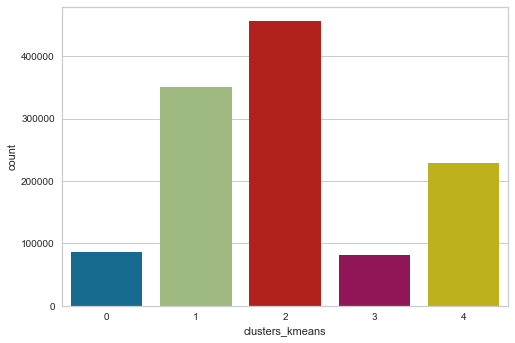

In [10]:
sns.countplot(data=spot_df3, x="clusters_kmeans")

In [11]:
spot_df3["clusters_kmeans"].value_counts()

2    456264
1    349840
4    229335
0     86419
3     82167
Name: clusters_kmeans, dtype: int64

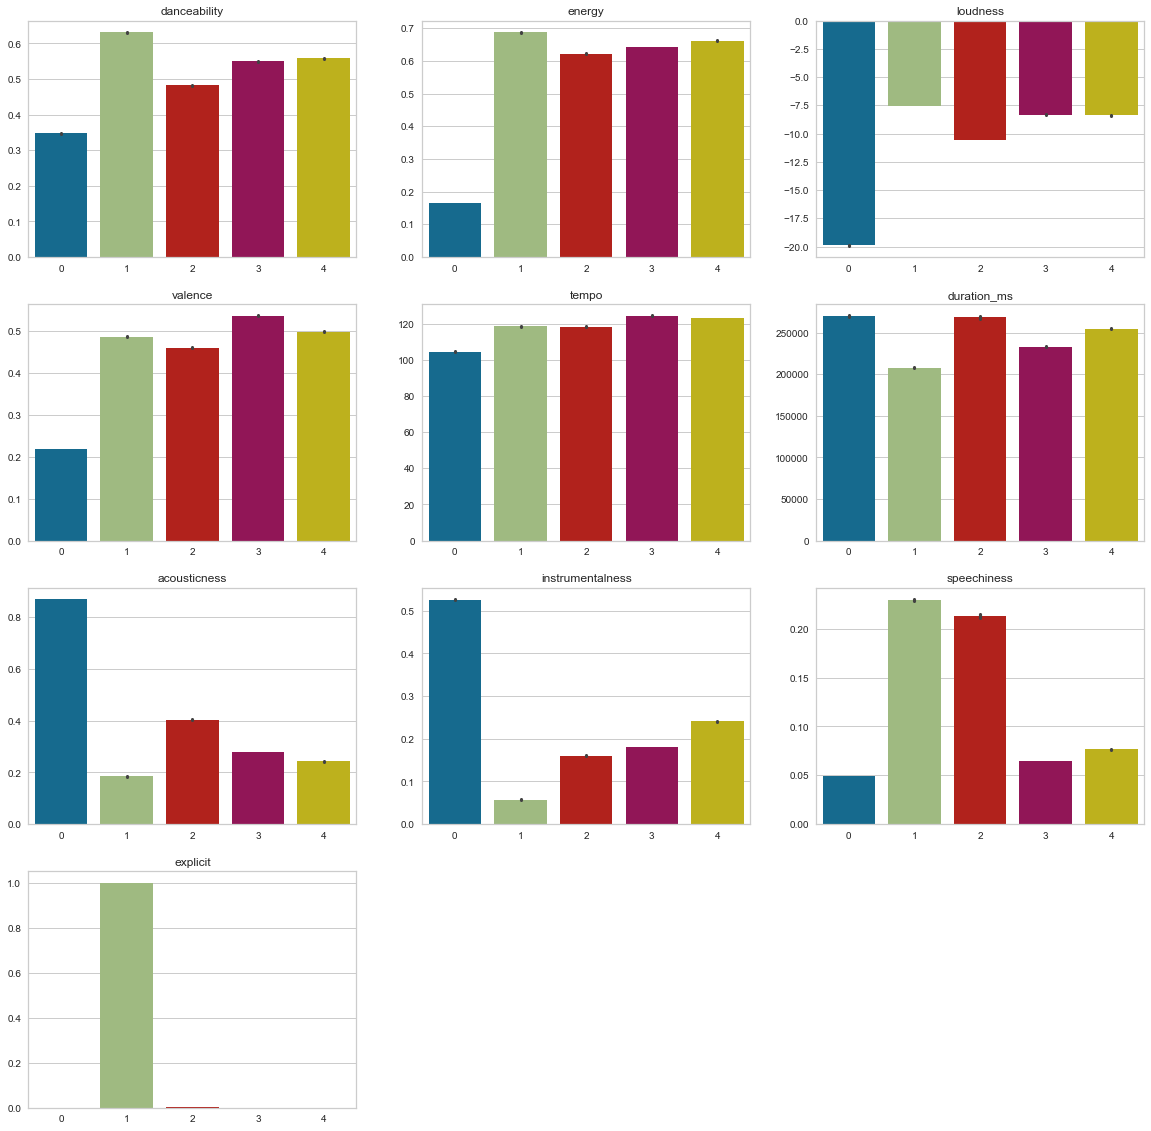

In [35]:
import math

var_list = ["danceability", "energy", "loudness", 
            "valence", "tempo", "duration_ms", "acousticness",
            "instrumentalness", "speechiness", "explicit"]

rows = math.ceil(len(var_list)/3)

fig, axs = plt.subplots(rows, 3, figsize=(20, 5*rows))

for i, ax in zip(var_list, axs.flat):
    g = sns.barplot(data=spot_df3, x='clusters_kmeans', y=i, ax=ax)
    ax.set(xlabel='', ylabel='', title=i)

for i in axs.flat[::-1][:rows*3-len(var_list)]:
    i.set_axis_off()

plt.show()

# Step 6: PCA KMeans Clustering

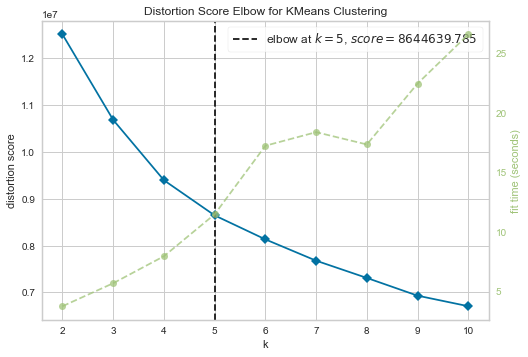

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [14]:
# Re-determining the number of clusters to use:

pipe = make_pipeline(StandardScaler(), PCA(n_components=0.9), KElbowVisualizer(KMeans()))

pipe.fit(spot_df2)
pipe[2].show()

In [15]:
# Determine the Explained Variance of each PC before
    # The n_components=0.9 resulted in 10 PCs vs. 13 original dimensions

pipe["pca"].explained_variance_ratio_.cumsum()

array([0.24845654, 0.37894835, 0.47984018, 0.56502739, 0.63550656,
       0.70251755, 0.76748204, 0.82788748, 0.88194314, 0.92469147])

In [15]:
# Complete clustering and add cluster labels to dataframe
pipe = make_pipeline(StandardScaler(), PCA(n_components=0.9), KMeans(n_clusters=5, random_state=42))

pipe.fit(spot_df2)

values = pipe[:2].transform(spot_df2)

pca_labels = [f'PC{idx+1}' for idx, i in enumerate(values.T)]

spot_df4 = spot_df2.copy()

spot_df4 = spot_df4.join(pd.DataFrame(values, columns=pca_labels))

spot_df4['clusters_kmeans_pca'] = pipe['kmeans'].labels_

In [16]:
spot_df4

,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,clusters_kmeans_pca
0,0,0.470,0.978,7,-5.399,1,0.0727,0.02610,0.000011,0.3560,...,0.845348,0.216042,0.540063,-0.910093,0.493465,-0.386387,-0.707653,-0.189626,0.198096,0
1,1,0.599,0.957,11,-5.764,1,0.1880,0.01290,0.000071,0.1550,...,-1.690847,1.561833,-0.290768,1.105482,-0.144768,-0.201632,-2.575969,-0.762797,-1.165640,1
2,0,0.315,0.970,7,-5.424,1,0.4830,0.02340,0.000002,0.1220,...,-0.175729,1.531351,0.845120,-0.033424,-1.006915,0.946317,-0.991129,-0.021223,3.014602,0
3,1,0.440,0.967,11,-5.830,0,0.2370,0.16300,0.000004,0.1210,...,-1.906286,2.551408,-1.440956,1.139911,-0.304133,-0.748232,-1.444825,-0.047448,-0.926246,1
4,0,0.426,0.929,2,-6.729,1,0.0701,0.00162,0.105000,0.0789,...,1.038234,-0.708902,0.750388,0.600299,-0.223477,-0.639492,-0.320828,0.062666,0.679395,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204020,0,0.264,0.966,5,-6.970,0,0.0672,0.00935,0.002240,0.3370,...,1.672187,1.343242,-0.160212,-0.615367,-0.804187,-0.484754,0.580778,1.186612,0.165472,0
1204021,0,0.796,0.701,11,-6.602,0,0.0883,0.10400,0.644000,0.0749,...,0.378393,0.091417,-2.693106,0.327063,0.474984,0.871882,0.633056,-1.114503,0.081937,4
1204022,0,0.785,0.796,9,-5.960,0,0.0564,0.03040,0.918000,0.0664,...,1.099966,0.514276,-2.317526,0.952510,0.219687,0.358377,0.731334,-1.429602,0.178107,4
1204023,0,0.665,0.856,6,-6.788,0,0.0409,0.00007,0.776000,0.1170,...,1.395512,0.803677,-1.438737,0.977980,-0.144592,-0.456303,0.770143,-0.793423,0.303210,0


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

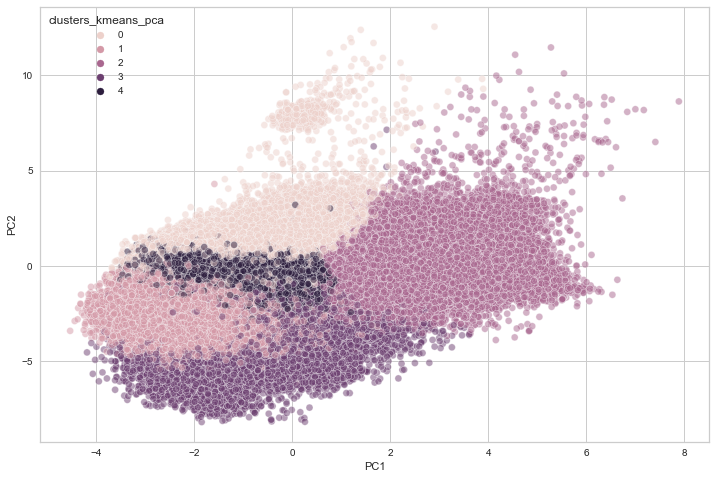

In [17]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=spot_df4, x="PC1", y="PC2", hue="clusters_kmeans_pca", alpha=0.5)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

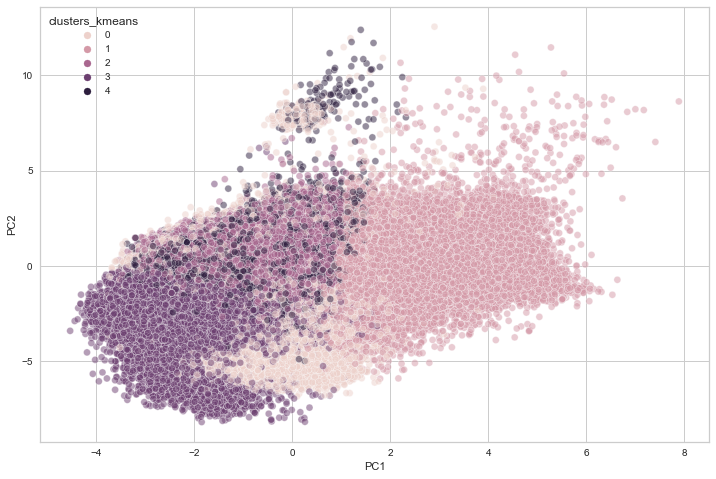

In [18]:
# compare to before PCA:

spot_df4["clusters_kmeans"] = spot_df3["clusters_kmeans"]

plt.figure(figsize=(12,8))
sns.scatterplot(data=spot_df4, x="PC1", y="PC2", hue="clusters_kmeans", alpha=0.5)

/var/folders/dd/d_ljzvwx7z19td2zp32spj8c0000gn/T/ipykernel_93772/1220797844.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')


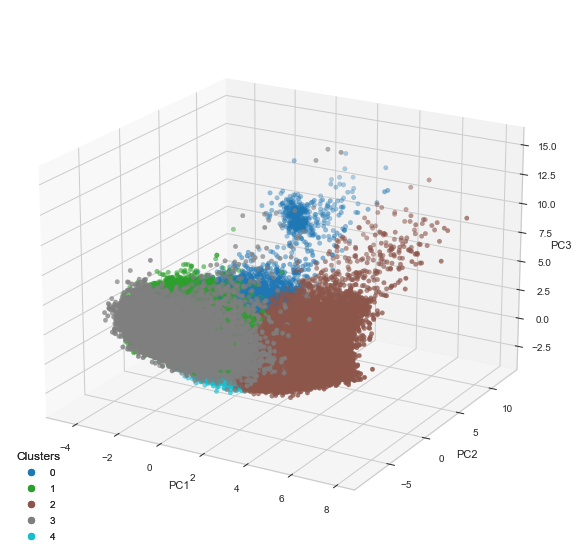

In [33]:
# 3D Scatter Plot - 20 degree angle

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter = ax.scatter(
    xs=spot_df4["PC1"], 
    ys=spot_df4["PC2"], 
    zs=spot_df4["PC3"], 
    c=spot_df4["clusters_kmeans_pca"], 
    cmap='tab10'
)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Clusters")
ax.add_artist(legend1)

ax.view_init(20)
    
plt.show()

/var/folders/dd/d_ljzvwx7z19td2zp32spj8c0000gn/T/ipykernel_93772/4261677521.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')


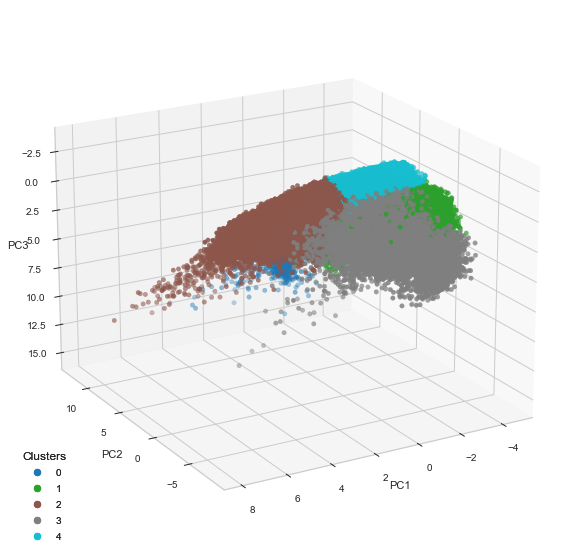

In [34]:
# 3D Scatter Plot - 20 degree angle + left

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter = ax.scatter(
    xs=spot_df4["PC1"], 
    ys=spot_df4["PC2"], 
    zs=spot_df4["PC3"], 
    c=spot_df4["clusters_kmeans_pca"], 
    cmap='tab10'
)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Clusters")
ax.add_artist(legend1)

ax.view_init(340)
    
plt.show()

# Step 7: Characterization (KMeans, PCA)

<AxesSubplot:xlabel='clusters_kmeans_pca', ylabel='count'>

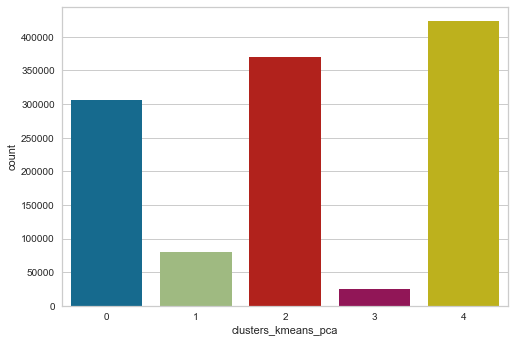

In [23]:
sns.countplot(data=spot_df4, x="clusters_kmeans_pca")

In [25]:
spot_df4["clusters_kmeans_pca"].value_counts()

4    423502
2    369429
0    305556
1     80161
3     25377
Name: clusters_kmeans_pca, dtype: int64

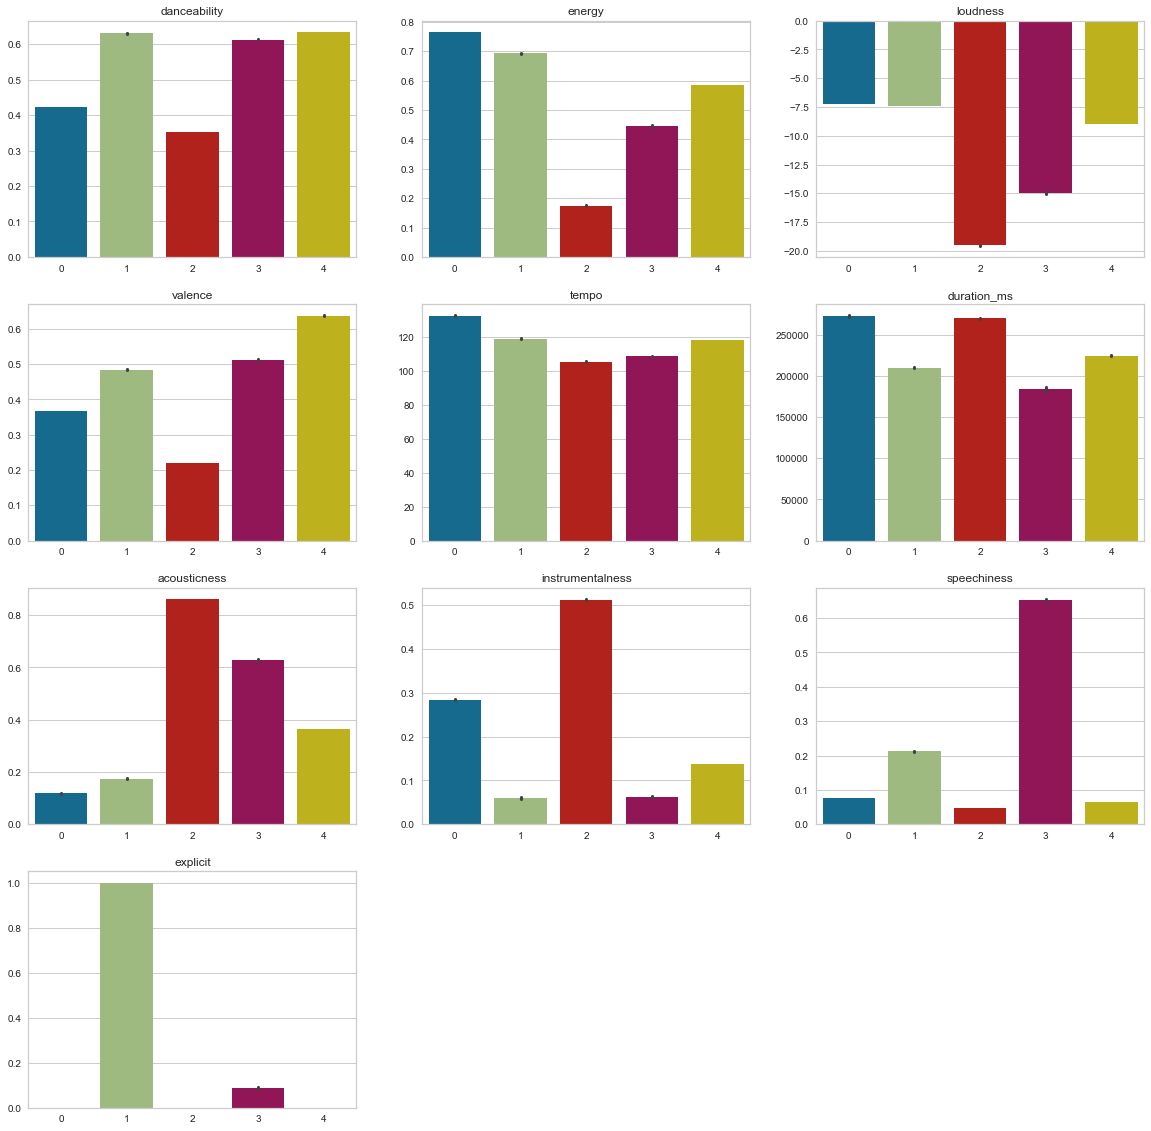

In [26]:
import math

var_list = ["danceability", "energy", "loudness", 
            "valence", "tempo", "duration_ms", "acousticness",
            "instrumentalness", "speechiness", "explicit"]

rows = math.ceil(len(var_list)/3)

fig, axs = plt.subplots(rows, 3, figsize=(20, 5*rows))

for i, ax in zip(var_list, axs.flat):
    g = sns.barplot(data=spot_df4, x='clusters_kmeans_pca', y=i, ax=ax)
    ax.set(xlabel='', ylabel='', title=i)

for i in axs.flat[::-1][:rows*3-len(var_list)]:
    i.set_axis_off()

plt.show()

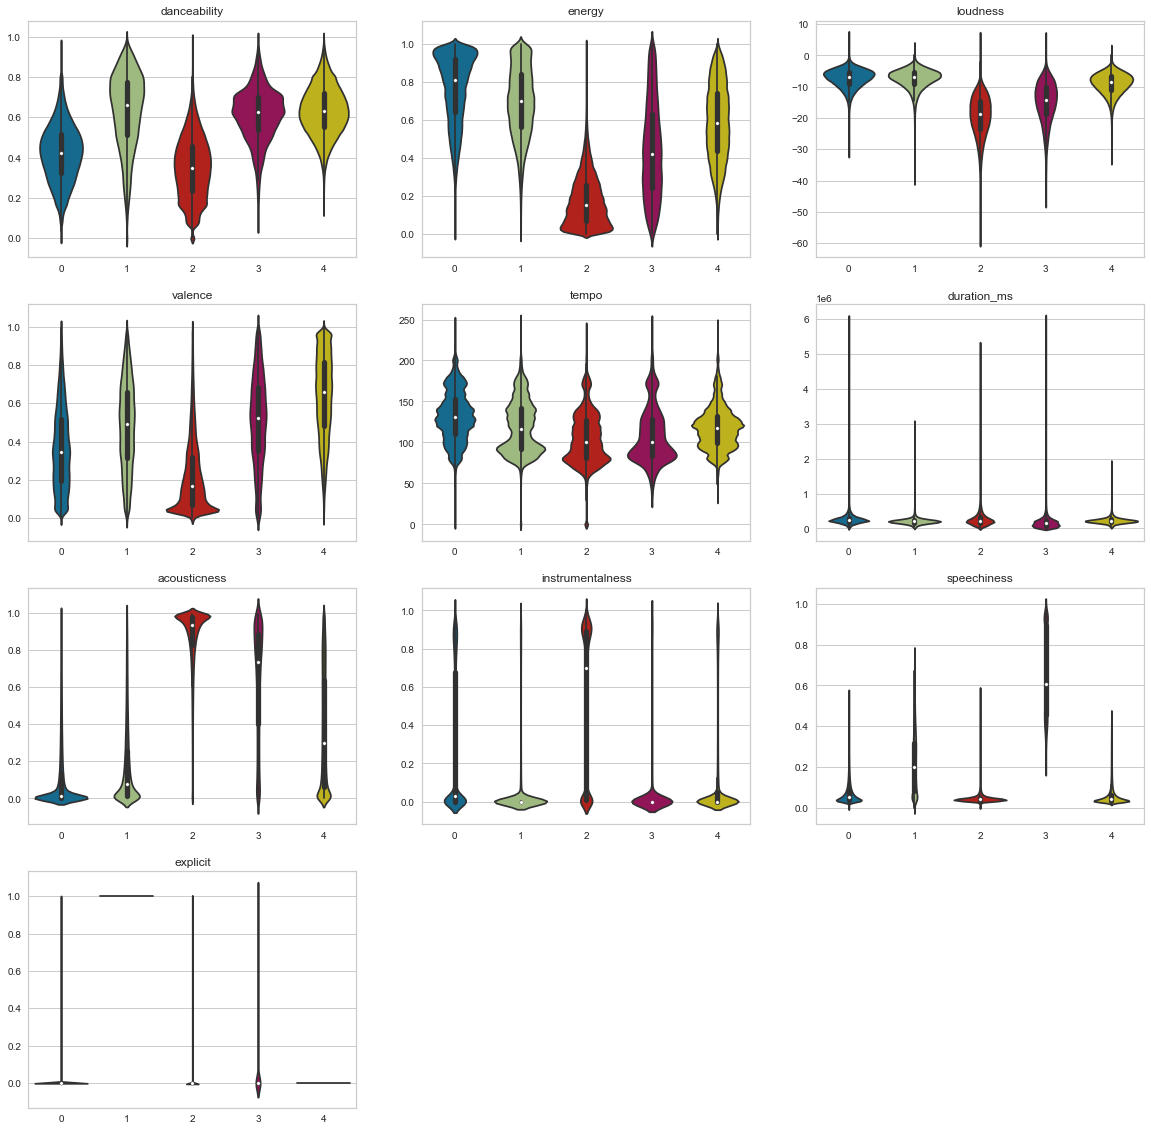

In [27]:
import math

var_list = ["danceability", "energy", "loudness", 
            "valence", "tempo", "duration_ms", "acousticness",
            "instrumentalness", "speechiness", "explicit"]

rows = math.ceil(len(var_list)/3)

fig, axs = plt.subplots(rows, 3, figsize=(20, 5*rows))

for i, ax in zip(var_list, axs.flat):
    g = sns.violinplot(data=spot_df4, x='clusters_kmeans_pca', y=i, ax=ax)
    ax.set(xlabel='', ylabel='', title=i)

for i in axs.flat[::-1][:rows*3-len(var_list)]:
    i.set_axis_off()

plt.show()

# Step 8: Merge w/ OG DF for Decade Comparison

In [151]:
spot_df5 = spot_df.copy()

spot_df5["clusters_kmeans"] = spot_df3["clusters_kmeans"]
spot_df5["clusters_kmeans_pca"] = spot_df4["clusters_kmeans_pca"]

spot_df5

,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,year,clusters_kmeans,clusters_kmeans_pca
0,0,0.470,0.978,7,-5.399,1,0.0727,0.02610,0.000011,0.3560,0.503,117.906,210133,1999,0,1
1,1,0.599,0.957,11,-5.764,1,0.1880,0.01290,0.000071,0.1550,0.489,103.680,206200,1999,3,4
2,0,0.315,0.970,7,-5.424,1,0.4830,0.02340,0.000002,0.1220,0.370,149.749,298893,1999,0,1
3,1,0.440,0.967,11,-5.830,0,0.2370,0.16300,0.000004,0.1210,0.574,96.752,213640,1999,3,4
4,0,0.426,0.929,2,-6.729,1,0.0701,0.00162,0.105000,0.0789,0.539,127.059,205600,1999,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204020,0,0.264,0.966,5,-6.970,0,0.0672,0.00935,0.002240,0.3370,0.415,159.586,276213,2014,1,3
1204021,0,0.796,0.701,11,-6.602,0,0.0883,0.10400,0.644000,0.0749,0.781,121.980,363179,2014,1,3
1204022,0,0.785,0.796,9,-5.960,0,0.0564,0.03040,0.918000,0.0664,0.467,121.996,385335,2014,1,3
1204023,0,0.665,0.856,6,-6.788,0,0.0409,0.00007,0.776000,0.1170,0.227,124.986,324455,2014,1,3


In [158]:
spot_df5.sort_values(by="year", ascending=True)

,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,year,clusters_kmeans,clusters_kmeans_pca
815355,0,0.657,0.550,5,-13.842,0,0.2810,0.01800,0.2450,0.2410,0.964,179.904,138666,0,1,3
815351,0,0.795,0.562,2,-11.327,1,0.0519,0.01560,0.4390,0.0860,0.389,109.985,183000,0,0,1
815352,0,0.762,0.328,2,-14.319,0,0.0950,0.88700,0.9090,0.1060,0.728,92.962,145161,0,1,3
815353,0,0.671,0.545,6,-15.363,0,0.0662,0.00956,0.9020,0.0455,0.893,97.865,176561,0,1,3
815354,0,0.759,0.582,10,-12.985,0,0.1280,0.00544,0.8950,0.0538,0.537,89.989,192000,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084802,1,0.255,0.816,4,-8.315,1,0.3140,0.00119,0.0278,0.3120,0.803,85.135,182587,2020,3,4
1084803,1,0.318,0.820,0,-8.755,1,0.1140,0.17000,0.0000,0.2060,0.653,136.796,154022,2020,3,4
1084804,1,0.511,0.870,8,-8.975,0,0.3800,0.68000,0.0000,0.5860,0.627,78.549,180054,2020,3,4
1084797,1,0.361,0.725,1,-9.782,1,0.3020,0.60000,0.0000,0.3750,0.668,83.979,147248,2020,3,4
